In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, random_split
from torchvision import datasets, transforms, models
from torchvision.transforms import ToTensor
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import precision_score, recall_score, f1_score
import zipfile
import os
from tqdm import tqdm

In [1]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("abdallahalidev/plantvillage-dataset")

print("Path to dataset files:", path)

Path to dataset files: /kaggle/input/plantvillage-dataset


In [3]:
path = "/kaggle/input/plantvillage-dataset/color"

In [4]:
# Loop through each class folder
for class_name in sorted(os.listdir(path)):
    class_path = os.path.join(path, class_name)
    if os.path.isdir(class_path):
        # Count only files (ignore subfolders, if any)
        image_count = sum(
            1 for file in os.listdir(class_path)
            if os.path.isfile(os.path.join(class_path, file))
        )
        print(f"{class_name}: {image_count} images")

Apple___Apple_scab: 630 images
Apple___Black_rot: 621 images
Apple___Cedar_apple_rust: 275 images
Apple___healthy: 1645 images
Blueberry___healthy: 1502 images
Cherry_(including_sour)___Powdery_mildew: 1052 images
Cherry_(including_sour)___healthy: 854 images
Corn_(maize)___Cercospora_leaf_spot Gray_leaf_spot: 513 images
Corn_(maize)___Common_rust_: 1192 images
Corn_(maize)___Northern_Leaf_Blight: 985 images
Corn_(maize)___healthy: 1162 images
Grape___Black_rot: 1180 images
Grape___Esca_(Black_Measles): 1383 images
Grape___Leaf_blight_(Isariopsis_Leaf_Spot): 1076 images
Grape___healthy: 423 images
Orange___Haunglongbing_(Citrus_greening): 5507 images
Peach___Bacterial_spot: 2297 images
Peach___healthy: 360 images
Pepper,_bell___Bacterial_spot: 997 images
Pepper,_bell___healthy: 1478 images
Potato___Early_blight: 1000 images
Potato___Late_blight: 1000 images
Potato___healthy: 152 images
Raspberry___healthy: 371 images
Soybean___healthy: 5090 images
Squash___Powdery_mildew: 1835 images
S

In [7]:
import os
import shutil
import random
from pathlib import Path


random.seed(42)


source_dir = '/kaggle/input/plantvillage-dataset/color'
dest_dir   = '/kaggle/working/plantvillage-balanced'
min_required = 350


os.makedirs(dest_dir, exist_ok=True)


class_counts = {}
for class_name in os.listdir(source_dir):
    class_path = os.path.join(source_dir, class_name)
    if os.path.isdir(class_path):
        image_files = [f for f in os.listdir(class_path)
                       if f.lower().endswith(('.png', '.jpg', '.jpeg'))]
        class_counts[class_name] = len(image_files)

print("Found classes:", len(class_counts))
print("Counts per class:", class_counts)


kept, skipped = [], []
for class_name, count in class_counts.items():
    src_class_path = os.path.join(source_dir, class_name)
    dst_class_path = os.path.join(dest_dir, class_name)

   
    if count < min_required:
        skipped.append((class_name, count))
        continue

    os.makedirs(dst_class_path, exist_ok=True)

    
    image_files = [f for f in os.listdir(src_class_path)
                   if f.lower().endswith(('.png', '.jpg', '.jpeg'))]

   
    sampled_files = random.sample(image_files, min_required)

    for filename in sampled_files:
        src = os.path.join(src_class_path, filename)
        dst = os.path.join(dst_class_path, filename)
        shutil.copy2(src, dst)

    kept.append((class_name, min_required))

print("\nSummary")
print("---------")
print(f"Kept classes (exactly {min_required} each): {len(kept)}")
for name, cnt in kept:
    print(f"  - {name}: {cnt}")

print(f"\nSkipped classes (< {min_required} images): {len(skipped)}")
for name, cnt in skipped:
    print(f"  - {name}: {cnt}")

print("\nBalanced dataset created at:", dest_dir)

Found classes: 38
Counts per class: {'Tomato___Late_blight': 1909, 'Tomato___healthy': 1591, 'Grape___healthy': 423, 'Orange___Haunglongbing_(Citrus_greening)': 5507, 'Soybean___healthy': 5090, 'Squash___Powdery_mildew': 1835, 'Potato___healthy': 152, 'Corn_(maize)___Northern_Leaf_Blight': 985, 'Tomato___Early_blight': 1000, 'Tomato___Septoria_leaf_spot': 1771, 'Corn_(maize)___Cercospora_leaf_spot Gray_leaf_spot': 513, 'Strawberry___Leaf_scorch': 1109, 'Peach___healthy': 360, 'Apple___Apple_scab': 630, 'Tomato___Tomato_Yellow_Leaf_Curl_Virus': 5357, 'Tomato___Bacterial_spot': 2127, 'Apple___Black_rot': 621, 'Blueberry___healthy': 1502, 'Cherry_(including_sour)___Powdery_mildew': 1052, 'Peach___Bacterial_spot': 2297, 'Apple___Cedar_apple_rust': 275, 'Tomato___Target_Spot': 1404, 'Pepper,_bell___healthy': 1478, 'Grape___Leaf_blight_(Isariopsis_Leaf_Spot)': 1076, 'Potato___Late_blight': 1000, 'Tomato___Tomato_mosaic_virus': 373, 'Strawberry___healthy': 456, 'Apple___healthy': 1645, 'Grape

In [8]:
transform_train = transforms.Compose([
    transforms.RandomResizedCrop(224),     
    transforms.RandomHorizontalFlip(),      
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

transform_test = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])


dataset = datasets.ImageFolder(root="/kaggle/working/plantvillage-balanced", transform=transform_train)
train_size = int(0.7 * len(dataset))
val_size = int(0.2 * len(dataset))
test_size = len(dataset) - train_size - val_size
train_dataset, val_dataset, test_dataset = random_split(dataset, [train_size, val_size, test_size])



val_dataset.dataset.transform = transform_test
test_dataset.dataset.transform = transform_test

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

class_names = dataset.classes
num_classes = len(class_names)

In [9]:
class_names = dataset.classes
num_classes = len(class_names)

In [10]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import models
from torchsummary import summary

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# FIX: Subset -> access underlying dataset
class_names = train_dataset.dataset.classes
total_class = len(class_names)

learning_rate = 0.0001

model = models.resnet50(pretrained=True)

# Freeze backbone
for param in model.parameters():
    param.requires_grad = False

# Replace head
num_ftrs = model.fc.in_features
model.fc = nn.Linear(num_ftrs, total_class)

model = model.to(device)

optimizer = optim.Adam(model.fc.parameters(), lr=learning_rate)
criterion = nn.CrossEntropyLoss()

summary(model, input_size=(3, 224, 224))


/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 208MB/s]


----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 112, 112]           9,408
       BatchNorm2d-2         [-1, 64, 112, 112]             128
              ReLU-3         [-1, 64, 112, 112]               0
         MaxPool2d-4           [-1, 64, 56, 56]               0
            Conv2d-5           [-1, 64, 56, 56]           4,096
       BatchNorm2d-6           [-1, 64, 56, 56]             128
              ReLU-7           [-1, 64, 56, 56]               0
            Conv2d-8           [-1, 64, 56, 56]          36,864
       BatchNorm2d-9           [-1, 64, 56, 56]             128
             ReLU-10           [-1, 64, 56, 56]               0
           Conv2d-11          [-1, 256, 56, 56]          16,384
      BatchNorm2d-12          [-1, 256, 56, 56]             512
           Conv2d-13          [-1, 256, 56, 56]          16,384
      BatchNorm2d-14          [-1, 256,

In [11]:
class EarlyStopping:

    def __init__(self, patience=5):

        self.patience = patience
        self.counter = 0
        self.best_loss = np.inf

    def check_early_stop(self, val_loss):
        if val_loss < self.best_loss:
            self.best_loss = val_loss
            self.counter = 0
        else:
            self.counter += 1
            if self.counter >= self.patience:
                return True
        return False

In [12]:
from tqdm import tqdm  
from torch.cuda.amp import autocast, GradScaler  
from torchvision import models
import torch.nn as nn
import torch.optim as optim


num_epochs = 50  


model = models.resnet50(pretrained=True)
for param in model.parameters():
    param.requires_grad = False
model.fc = nn.Linear(model.fc.in_features, num_classes)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

criterion = nn.CrossEntropyLoss()  
optimizer = optim.Adam(model.fc.parameters(), lr=0.001)  

early_stopping = EarlyStopping(patience=5)  
train_losses, val_losses = [], []  

scaler = GradScaler()


for epoch in range(num_epochs):

    print(f"Epoch {epoch+1}/{num_epochs}")

    model.train()
    train_loss = 0
    for images, labels in tqdm(train_loader, desc="Training", leave=False):
        images, labels = images.to('cuda'), labels.to('cuda')
        optimizer.zero_grad()
        with autocast():
            outputs = model(images)
            loss = criterion(outputs, labels)
        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()
        train_loss += loss.item()


    model.eval()
    val_loss = 0
    with torch.no_grad():
        for images, labels in tqdm(val_loader, desc="Validation", leave=False):
            images, labels = images.to('cuda'), labels.to('cuda')
            with autocast():
                outputs = model(images)
                loss = criterion(outputs, labels)
            val_loss += loss.item()

    avg_train_loss = train_loss / len(train_loader)
    avg_val_loss = val_loss / len(val_loader)
    train_losses.append(avg_train_loss)
    val_losses.append(avg_val_loss)

    print(f"Train Loss: {avg_train_loss:.4f}, Validation Loss: {avg_val_loss:.4f}")

    if early_stopping.check_early_stop(avg_val_loss):
        print("Early stopping triggered.")
        break



/tmp/ipykernel_36/2197084450.py:24: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler()


Epoch 1/50


Training:   0%|          | 0/276 [00:00<?, ?it/s]/tmp/ipykernel_36/2197084450.py:36: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
Validation:   0%|          | 0/79 [00:00<?, ?it/s]         /tmp/ipykernel_36/2197084450.py:50: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Train Loss: 1.1597, Validation Loss: 0.4387
Epoch 2/50


Train Loss: 0.3881, Validation Loss: 0.3240
Epoch 3/50


Train Loss: 0.2769, Validation Loss: 0.2554
Epoch 4/50


Train Loss: 0.2252, Validation Loss: 0.2484
Epoch 5/50


Train Loss: 0.1894, Validation Loss: 0.2033
Epoch 6/50


Train Loss: 0.1656, Validation Loss: 0.1973
Epoch 7/50


Train Loss: 0.1523, Validation Loss: 0.1920
Epoch 8/50


Train Loss: 0.1352, Validation Loss: 0.2039
Epoch 9/50


Train Loss: 0.1173, Validation Loss: 0.1894
Epoch 10/50


Train Loss: 0.1109, Validation Loss: 0.1825
Epoch 11/50


Train Loss: 0.1197, Validation Loss: 0.1822
Epoch 12/50


Train Loss: 0.0988, Validation Loss: 0.1806
Epoch 13/50


Train Loss: 0.0933, Validation Loss: 0.1825
Epoch 14/50


Train Loss: 0.0872, Validation Loss: 0.1909
Epoch 15/50


Train Loss: 0.0814, Validation Loss: 0.1838
Epoch 16/50


Train Loss: 0.0768, Validation Loss: 0.2079
Epoch 17/50


Train Loss: 0.0759, Validation Loss: 0.1760
Epoch 18/50


Train Loss: 0.0705, Validation Loss: 0.1914
Epoch 19/50


Train Loss: 0.0757, Validation Loss: 0.1693
Epoch 20/50


Train Loss: 0.0619, Validation Loss: 0.1633
Epoch 21/50


Train Loss: 0.0654, Validation Loss: 0.1946
Epoch 22/50


Train Loss: 0.0538, Validation Loss: 0.1654
Epoch 23/50


Train Loss: 0.0588, Validation Loss: 0.1855
Epoch 24/50


Train Loss: 0.0572, Validation Loss: 0.1798
Epoch 25/50


Train Loss: 0.0534, Validation Loss: 0.1827
Early stopping triggered.


In [13]:

model_save_path = "resnet50_model.pth"  


torch.save(model.state_dict(), model_save_path)

print(f"Model saved to {model_save_path}")


Model saved to resnet50_model.pth


In [14]:
from sklearn.metrics import classification_report

all_preds = []
all_labels = []

with torch.no_grad():
    for images, labels in val_loader:
        images, labels = images.to('cuda'), labels.to('cuda')
        with autocast():
            outputs = model(images)
        preds = torch.argmax(outputs, dim=1)  
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())


report = classification_report(all_labels, all_preds, digits=4)
print("Classification Report:\n", report)


/tmp/ipykernel_36/2379966855.py:9: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Classification Report:
               precision    recall  f1-score   support

           0     0.8235    0.9859    0.8974        71
           1     0.9863    0.9863    0.9863        73
           2     0.9846    0.9697    0.9771        66
           3     1.0000    0.9868    0.9934        76
           4     1.0000    0.9605    0.9799        76
           5     1.0000    1.0000    1.0000        76
           6     0.8133    0.8714    0.8414        70
           7     1.0000    0.9861    0.9930        72
           8     0.8841    0.8026    0.8414        76
           9     0.9767    0.9882    0.9825        85
          10     0.8784    0.9701    0.9220        67
          11     0.9677    0.9091    0.9375        66
          12     0.9730    1.0000    0.9863        72
          13     1.0000    1.0000    1.0000        70
          14     1.0000    1.0000    1.0000        67
          15     1.0000    0.9014    0.9481        71
          16     0.9859    1.0000    0.9929        70
   

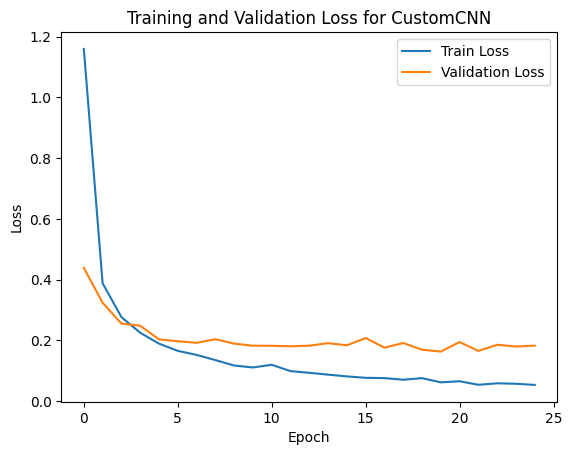

In [15]:
# Plotting loss curves
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title("Training and Validation Loss for CustomCNN")
plt.show()

/tmp/ipykernel_36/1691443750.py:28: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(enabled=(device.type=="cuda")):


Testing time: 4.82 sec  |  Throughput: 261.45 samples/sec
Confusion Matrix:
 [[44  0  0 ...  0  0  0]
 [ 0 35  0 ...  0  0  0]
 [ 0  0 30 ...  0  0  0]
 ...
 [ 0  0  0 ... 39  0  0]
 [ 0  0  0 ...  0 36  0]
 [ 0  0  0 ...  0  0 32]]

Confusion Matrix (row-normalized):
[[1.    0.    0.    ... 0.    0.    0.   ]
 [0.    1.    0.    ... 0.    0.    0.   ]
 [0.    0.    1.    ... 0.    0.    0.   ]
 ...
 [0.    0.    0.    ... 1.    0.    0.   ]
 [0.    0.    0.    ... 0.    0.973 0.   ]
 [0.    0.    0.    ... 0.    0.    1.   ]]


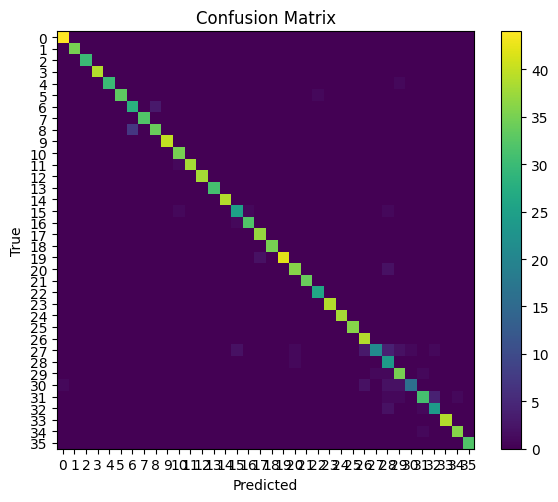

Per-class ROC AUC:
  Class 0: 1.0000
  Class 1: 1.0000
  Class 2: 1.0000
  Class 3: 1.0000
  Class 4: 0.9979
  Class 5: 0.9999
  Class 6: 0.9977
  Class 7: 1.0000
  Class 8: 0.9984
  Class 9: 1.0000
  Class 10: 1.0000
  Class 11: 1.0000
  Class 12: 1.0000
  Class 13: 1.0000
  Class 14: 1.0000
  Class 15: 0.9995
  Class 16: 1.0000
  Class 17: 1.0000
  Class 18: 1.0000
  Class 19: 1.0000
  Class 20: 0.9967
  Class 21: 1.0000
  Class 22: 0.9999
  Class 23: 1.0000
  Class 24: 1.0000
  Class 25: 1.0000
  Class 26: 0.9997
  Class 27: 0.9950
  Class 28: 0.9979
  Class 29: 0.9988
  Class 30: 0.9982
  Class 31: 0.9976
  Class 32: 0.9980
  Class 33: 1.0000
  Class 34: 1.0000
  Class 35: 1.0000
Micro-average ROC AUC: 0.9995
Macro-average ROC AUC: 0.9994


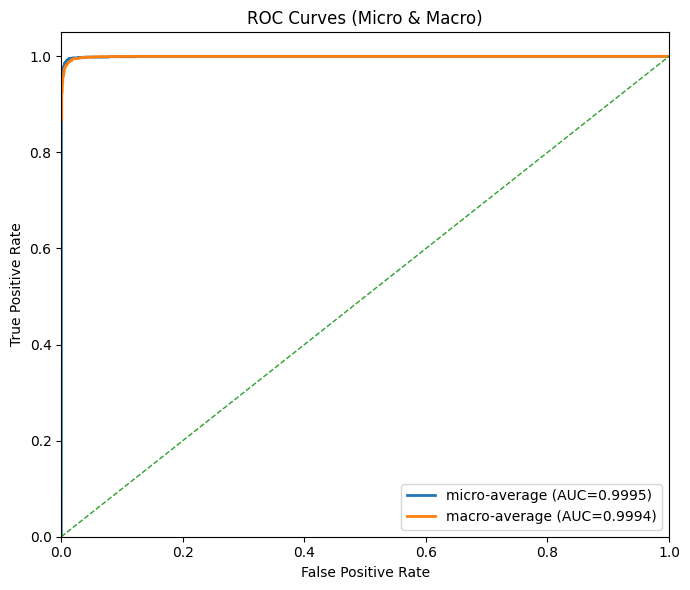

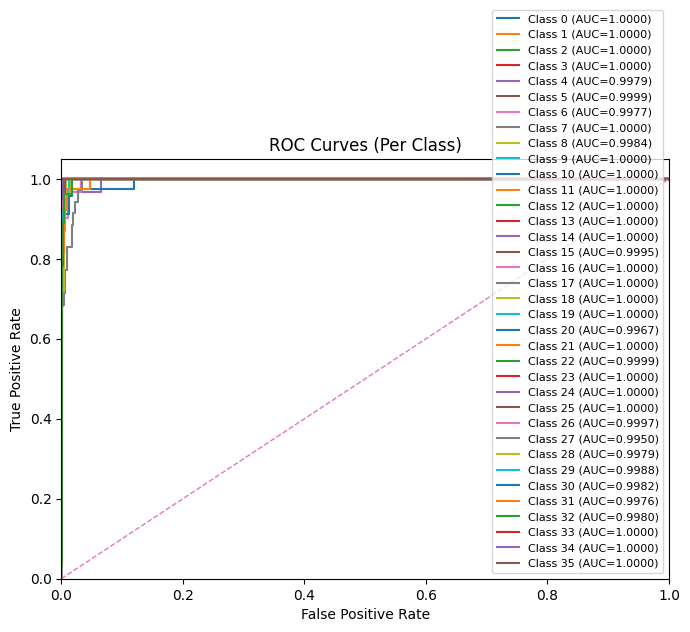


Classification Report (test):
              precision    recall  f1-score   support

           0     0.9778    1.0000    0.9888        44
           1     1.0000    1.0000    1.0000        35
           2     1.0000    1.0000    1.0000        30
           3     1.0000    1.0000    1.0000        39
           4     1.0000    0.9677    0.9836        31
           5     1.0000    0.9706    0.9851        34
           6     0.8000    0.9032    0.8485        31
           7     1.0000    1.0000    1.0000        32
           8     0.9189    0.8293    0.8718        41
           9     1.0000    1.0000    1.0000        40
          10     0.9459    1.0000    0.9722        35
          11     1.0000    0.9744    0.9870        39
          12     1.0000    1.0000    1.0000        38
          13     1.0000    1.0000    1.0000        31
          14     1.0000    1.0000    1.0000        39
          15     0.8929    0.8929    0.8929        28
          16     0.9697    0.9697    0.9697       

In [16]:
import time
import numpy as np
import torch
import torch.nn.functional as F
from torch.cuda.amp import autocast
from sklearn.metrics import (
    confusion_matrix, roc_auc_score, roc_curve, auc, classification_report
)
from sklearn.preprocessing import label_binarize
import matplotlib.pyplot as plt

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model.eval()

all_logits   = []
all_probs    = []
all_preds    = []
all_labels   = []


loader = test_loader  

t_test_start = time.time()
with torch.no_grad():
    for images, labels in loader:
        images, labels = images.to(device), labels.to(device)
        with autocast(enabled=(device.type=="cuda")):
            logits = model(images)                        
            probs  = F.softmax(logits, dim=1)            

        preds = torch.argmax(probs, dim=1)

        all_logits.append(logits.detach().cpu().numpy())
        all_probs.append(probs.detach().cpu().numpy())
        all_preds.extend(preds.detach().cpu().numpy())
        all_labels.extend(labels.detach().cpu().numpy())

t_test_end = time.time()
total_test_time_sec = t_test_end - t_test_start
n_samples = len(all_preds)
print(f"Testing time: {total_test_time_sec:.2f} sec  |  Throughput: {n_samples/total_test_time_sec:.2f} samples/sec")

all_logits = np.concatenate(all_logits, axis=0)
all_probs  = np.concatenate(all_probs, axis=0)
all_preds  = np.array(all_preds)
all_labels = np.array(all_labels)

num_classes = all_probs.shape[1]
class_indices = list(range(num_classes))

# ====== (C) CONFUSION MATRIX ======
cm = confusion_matrix(all_labels, all_preds, labels=class_indices)
print("Confusion Matrix:\n", cm)

# simple text view
def print_cm(cm):
    row_sums = cm.sum(axis=1, keepdims=True).clip(min=1)
    norm_cm = cm / row_sums
    print("\nConfusion Matrix (row-normalized):")
    with np.printoptions(precision=3, suppress=True):
        print(norm_cm)

print_cm(cm)

# Optional: plot CM (no seaborn)
plt.figure(figsize=(6, 5))
plt.imshow(cm, interpolation='nearest')
plt.title('Confusion Matrix')
plt.colorbar()
tick_marks = np.arange(num_classes)
plt.xticks(tick_marks, tick_marks)
plt.yticks(tick_marks, tick_marks)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.tight_layout()
plt.show()


y_true_bin = label_binarize(all_labels, classes=class_indices) if num_classes > 2 else all_labels
y_score    = all_probs

if num_classes == 2:
   
    fpr, tpr, _ = roc_curve(y_true_bin, y_score[:, 1])
    roc_auc = auc(fpr, tpr)
    print(f"Binary ROC AUC: {roc_auc:.4f}")

    plt.figure(figsize=(6, 5))
    plt.plot(fpr, tpr, lw=2, label=f'ROC curve (AUC = {roc_auc:.4f})')
    plt.plot([0, 1], [0, 1], lw=1, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve (Binary)')
    plt.legend(loc="lower right")
    plt.tight_layout()
    plt.show()

else:
   
    fpr = {}
    tpr = {}
    roc_auc = {}
    for c in class_indices:
        fpr[c], tpr[c], _ = roc_curve(y_true_bin[:, c], y_score[:, c])
        roc_auc[c] = auc(fpr[c], tpr[c])

   
    fpr["micro"], tpr["micro"], _ = roc_curve(y_true_bin.ravel(), y_score.ravel())
    roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])


    all_fpr = np.unique(np.concatenate([fpr[c] for c in class_indices]))
 
    mean_tpr = np.zeros_like(all_fpr)
    for c in class_indices:
        mean_tpr += np.interp(all_fpr, fpr[c], tpr[c])
    mean_tpr /= num_classes
    fpr["macro"] = all_fpr
    tpr["macro"] = mean_tpr
    roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

    print("Per-class ROC AUC:")
    for c in class_indices:
        print(f"  Class {c}: {roc_auc[c]:.4f}")
    print(f"Micro-average ROC AUC: {roc_auc['micro']:.4f}")
    print(f"Macro-average ROC AUC: {roc_auc['macro']:.4f}")

    # Plot micro & macro
    plt.figure(figsize=(7, 6))
    plt.plot(fpr["micro"], tpr["micro"], lw=2, label=f'micro-average (AUC={roc_auc["micro"]:.4f})')
    plt.plot(fpr["macro"], tpr["macro"], lw=2, label=f'macro-average (AUC={roc_auc["macro"]:.4f})')
    plt.plot([0, 1], [0, 1], lw=1, linestyle='--')
    plt.xlim([0.0, 1.0]); plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate'); plt.ylabel('True Positive Rate')
    plt.title('ROC Curves (Micro & Macro)')
    plt.legend(loc="lower right")
    plt.tight_layout()
    plt.show()


    plt.figure(figsize=(7, 6))
    for c in class_indices:
        plt.plot(fpr[c], tpr[c], lw=1.5, label=f'Class {c} (AUC={roc_auc[c]:.4f})')
    plt.plot([0, 1], [0, 1], lw=1, linestyle='--')
    plt.xlim([0.0, 1.0]); plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate'); plt.ylabel('True Positive Rate')
    plt.title('ROC Curves (Per Class)')
    plt.legend(loc="lower right", fontsize=8)
    plt.tight_layout()
    plt.show()


print("\nClassification Report (test):")
print(classification_report(all_labels, all_preds, digits=4))


In [24]:
!pip install git+https://github.com/jacobgil/pytorch-grad-cam.git


!pip install lime

  Cloning https://github.com/jacobgil/pytorch-grad-cam.git to /tmp/pip-req-build-mx9bwagx
  Running command git clone --filter=blob:none --quiet https://github.com/jacobgil/pytorch-grad-cam.git /tmp/pip-req-build-mx9bwagx
  Resolved https://github.com/jacobgil/pytorch-grad-cam.git to commit 781dbc0d16ffa95b6d18b96b7b829840a82d93d1
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done


In [25]:
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
from pytorch_grad_cam import GradCAM
from pytorch_grad_cam.utils.image import show_cam_on_image
from pytorch_grad_cam.utils.model_targets import ClassifierOutputTarget

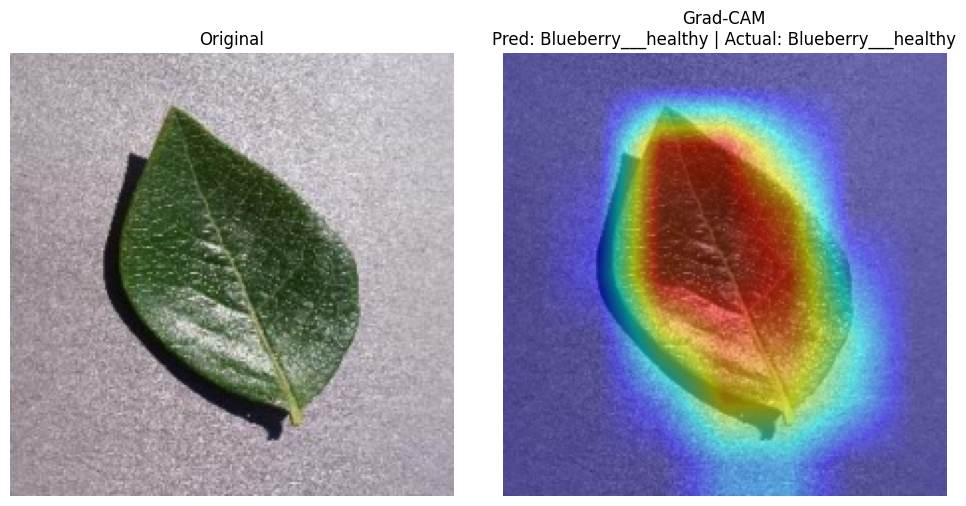

In [26]:
from pytorch_grad_cam import GradCAM
from pytorch_grad_cam.utils.model_targets import ClassifierOutputTarget
from pytorch_grad_cam.utils.image import show_cam_on_image
import matplotlib.pyplot as plt
import torch


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.eval().to(device)


for p in model.layer4.parameters():
    p.requires_grad_(True)


sample_image, label = test_dataset[0]
sample_image = sample_image.unsqueeze(0).to(device)


original_image_np = sample_image.squeeze(0).permute(1, 2, 0).detach().cpu().numpy()
original_image_np = (original_image_np * 0.5) + 0.5 
original_image_np = original_image_np.clip(0, 1)


target_layers = [model.layer4[-1]]


cam = GradCAM(model=model, target_layers=target_layers)


outputs = model(sample_image)
predicted_class = outputs.argmax(dim=1).item()


targets = [ClassifierOutputTarget(predicted_class)]


grayscale_cam = cam(input_tensor=sample_image, targets=targets, eigen_smooth=True)
heatmap = grayscale_cam[0]


result = show_cam_on_image(original_image_np, heatmap, use_rgb=True)


plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.title("Original")
plt.imshow(original_image_np)
plt.axis('off')

plt.subplot(1, 2, 2)
plt.title(f"Grad-CAM\nPred: {class_names[predicted_class]} | Actual: {class_names[label]}")
plt.imshow(result)
plt.axis('off')

plt.tight_layout()
plt.show()


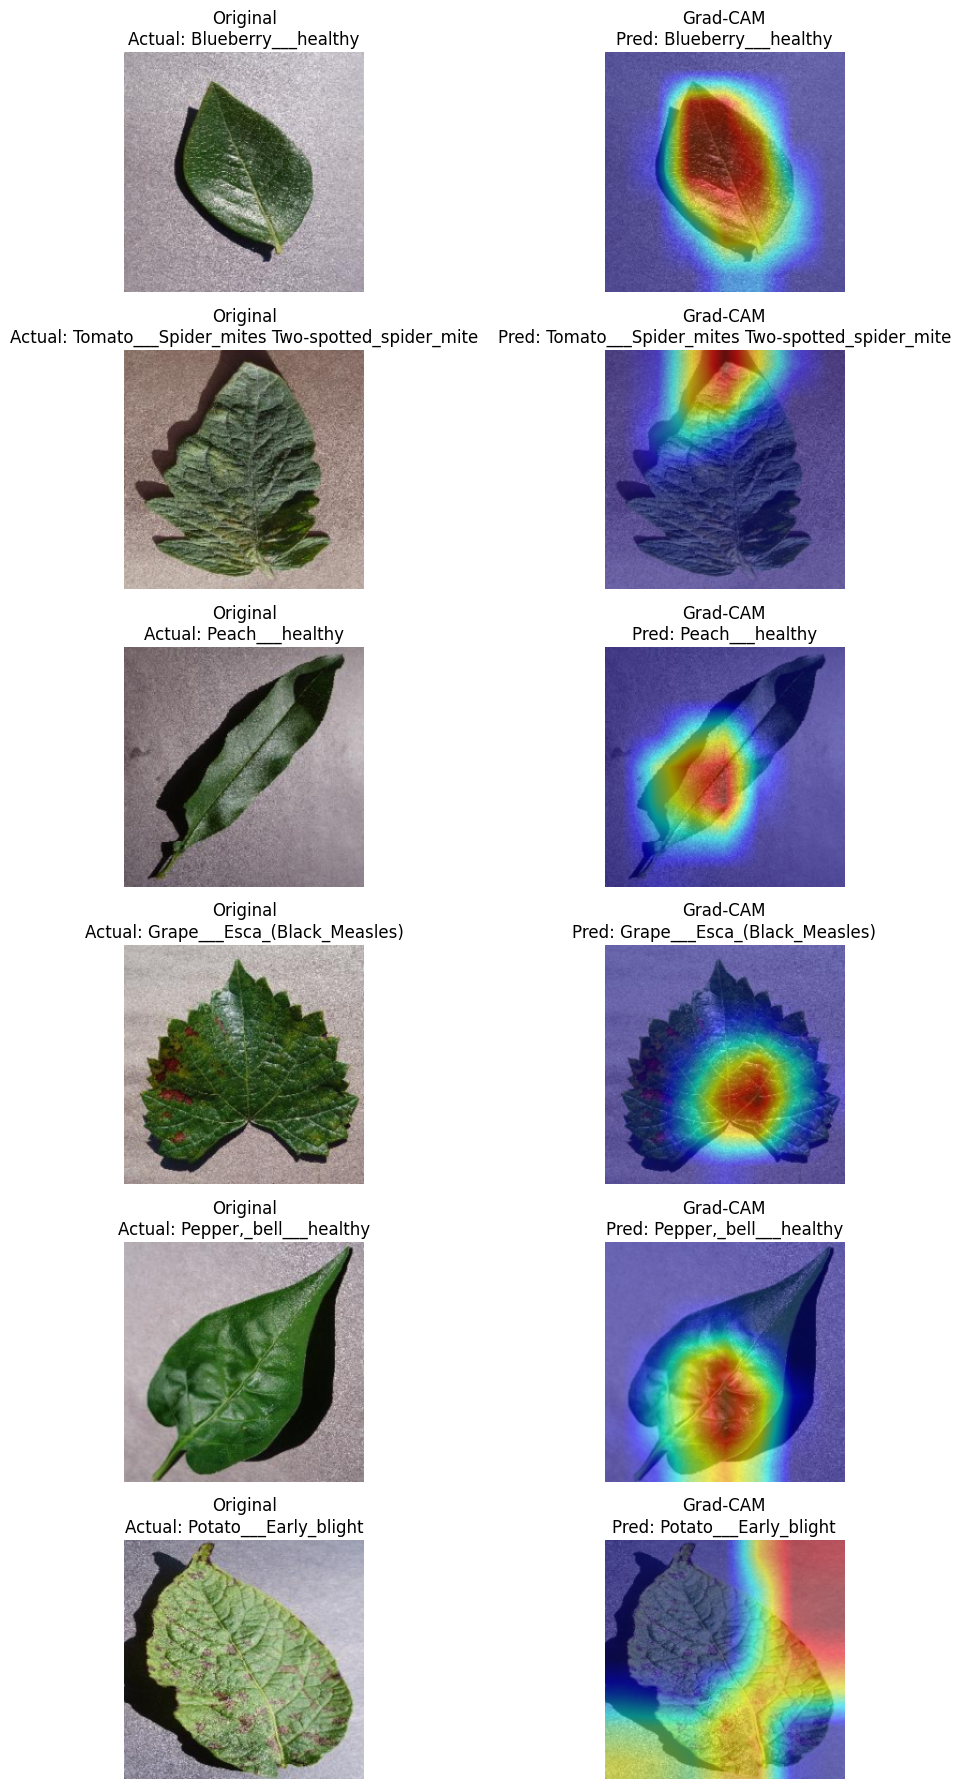

In [27]:
from pytorch_grad_cam import GradCAM
from pytorch_grad_cam.utils.model_targets import ClassifierOutputTarget
from pytorch_grad_cam.utils.image import show_cam_on_image
import matplotlib.pyplot as plt
import torch
import numpy as np


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.eval().to(device)


for p in model.layer4.parameters():
    p.requires_grad_(True)


target_layers = [model.layer4[-1]]
cam = GradCAM(model=model, target_layers=target_layers)


num_images_to_show = 6  
rows = num_images_to_show
cols = 2 

plt.figure(figsize=(12, rows * 3))

for i in range(num_images_to_show):
    img_t, label = test_dataset[i]
    x = img_t.unsqueeze(0).to(device)

  
    orig = img_t.permute(1,2,0).cpu().numpy()
    orig = (orig * 0.5) + 0.5
    orig = orig.clip(0, 1)

   
    outputs = model(x)
    pred = outputs.argmax(dim=1).item()
    targets = [ClassifierOutputTarget(pred)]
    grayscale_cam = cam(input_tensor=x, targets=targets, eigen_smooth=True)
    heatmap = grayscale_cam[0]
    overlay = show_cam_on_image(orig, heatmap, use_rgb=True)

    
    plt.subplot(rows, cols, i*cols + 1)
    plt.imshow(orig); plt.axis('off')
    plt.title(f"Original\nActual: {class_names[label]}")


    plt.subplot(rows, cols, i*cols + 2)
    plt.imshow(overlay); plt.axis('off')
    plt.title(f"Grad-CAM\nPred: {class_names[pred]}")

plt.tight_layout()
plt.show()